In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import plotly.graph_objects as go
import random
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

np.random.seed(0)
torch.manual_seed(0)

In [2]:
# Load the MNIST dataset

image_size = 16
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size,image_size)),
    transforms.Lambda(lambda x: x.view(image_size * image_size, 1)),
])
root_folder = '../src/mammoth/data/MNIST'
train_dataset = datasets.MNIST(root=root_folder, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_folder, train=False, download=True, transform=transform)

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 60000
Test dataset: 10000


Images shape: torch.Size([100, 256, 1])
Labels shape: torch.Size([100])


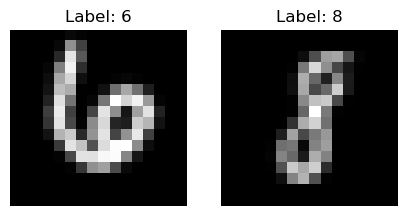

In [3]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# plot some images
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].view(image_size, image_size).numpy(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(image_size * image_size, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 10, bias=True))
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.normal_(layer.bias)

    def forward(self, x):
        x = x.view(-1, image_size * image_size)
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.relu(x)
        output = self.layers[-1](x)
        return output

model = MLP()

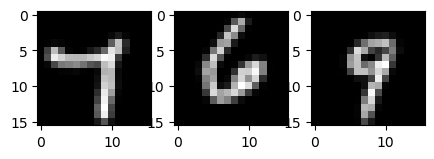

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images_plane = images[:3]
fig, axes = plt.subplots(1, 3, figsize=(5, 5))
for i in range(3):
    axes[i].imshow(images_plane[i].view(image_size, image_size).numpy(), cmap='gray')

In [6]:
def embedding(coordinates, images_plane):
    """
    Embedding of the 2D plane going through images_plane[0], images_plane[1], images_plane[2]
    in input space.
    """
    coordinates = torch.tensor(coordinates, dtype=torch.float32)
    return coordinates[0] * (images_plane[0] - images_plane[1]) + coordinates[1] * (images_plane[0] - images_plane[2]) + images_plane[0]

In [7]:
# Geometric utils
def compute_line_segment_intersection(p1, p2, line_coeffs):
    """
    Segment between two points p1, p2: p1 + t * (p2 - p1) with 0 <= t <= 1.
    Line a * x + b * y + c = 0 with line_coeffs: (a, b, c).
    Output: intersection points if it exists, None otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    
    p1_emb = embedding(p1[..., np.newaxis], images_plane)
    p2_emb = embedding(p2[..., np.newaxis], images_plane)

    w = line_coeffs[0]
    b = line_coeffs[1]

    denominator = w @ (p2_emb - p1_emb)
    if abs(denominator) < 1e-9:  # Parallel line    TODO: Check if the segment is on the line?
        return None

    t = -(b + w @ p1_emb) / denominator
    t = t.item()
    if 0 <= t <= 1:              # Check if intersection is within the segment
        return (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
    return None

def compute_line_region_intersection(convex_hull, line_coeffs):
    """
    convex_hull: scipy.spatial.ConvexHull object.
    line_coeffs: (a, b, c), defining the line a * x + b * y + c = 0.
    Output: list of intersection points.
    """
    intersections = []
    points = convex_hull.points
    for edge in convex_hull.simplices:
        p1, p2 = points[edge[0]], points[edge[1]]
        #p1 = embedding(p1[..., np.newaxis], images)
        #p2 = embedding(p2[..., np.newaxis], images)
        #print(p1.shape)
        point = compute_line_segment_intersection(p1, p2, line_coeffs)
        if point is not None:
            intersections.append(point)
    return intersections

# Definition of main object: the region
class ActivationRegion():
    def __init__(self, vertices, activation_pattern, linear_map):
        self.convex_hull = ConvexHull(vertices)     # TODO: Might be an overkill? Just need the vertices
        self.activation_pattern = activation_pattern
        self.linear_map = linear_map

    def update_linear_map(self, W, b):
        A, c = self.linear_map
        a = self.activation_pattern
        A_new = a * W @ A
        c_new = a * W @ c + a * b.view(-1, 1)
        self.linear_map = (A_new, c_new)

# Utils for the counting
def set_empty_activation_pattern(regions, n_neurons):
    for region in regions:
        region.activation_pattern = torch.empty((n_neurons, 1), dtype=torch.float32)

def update_linear_maps(regions, W, b):
    for region in regions:
        region.update_linear_map(W, b)

In [8]:
def count_regions(model):
    n_in = model.layers[0].weight.shape[1]
    layers = model.layers

    init_region = ActivationRegion(
        vertices=np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, 1.0], [1.0, -1.0]]),
        activation_pattern=torch.empty((n_in, 1), dtype=torch.float32),
        linear_map=(torch.eye(n_in), torch.zeros(n_in, 1))
    )
    cut_counter = 0
    no_cut_counter = 0

    regions = [init_region]
    with torch.no_grad():
        for l in range(len(layers)-1):      # Iterate over hidden layers
            W = layers[l].weight            # TODO: Currently W, b requires grad. Faster if not?
            b = layers[l].bias
            n_neurons = W.shape[0]
            set_empty_activation_pattern(regions, n_neurons)
            for i in range(n_neurons):      # Iterate over neurons of current layer
                Wi = W[i]
                bi = b[i]
                new_regions = []
                idx_to_remove = []
                for idx, region in enumerate(regions):      # Iterate over regions
                    old_activation_pattern = region.activation_pattern
                    A, c = region.linear_map
                    vertices = region.convex_hull.points[region.convex_hull.vertices]
                    input = embedding(vertices.T, images_plane)
                    #input = torch.tensor(vertices, dtype=torch.float32).T
                    preactivation = Wi @ (A @ input + c) + bi
                    sign = torch.sign(preactivation)
                    if torch.unique(sign).shape[0] > 1:     # Region is cut
                        cut_counter += 1
                        intersection  = compute_line_region_intersection(region.convex_hull, line_coeffs=(Wi @ A, (Wi @ c).squeeze() + bi))
                        if len(intersection) > 0:           # TODO: Necessary? Imo this is useless, the region IS cut.
                            idx_to_remove.append(idx)
                            new_vertices = np.concatenate((vertices[np.where(sign > 0)[0]], intersection), axis=0)
                            new_activation_pattern = old_activation_pattern.clone()
                            new_activation_pattern[i] = 1
                            new_region = ActivationRegion(
                                vertices=new_vertices,
                                activation_pattern=new_activation_pattern,
                                linear_map=(A, c)
                            )
                            new_regions.append(new_region)

                            new_vertices = np.concatenate((vertices[np.where(sign < 0)[0]], intersection), axis=0)
                            new_activation_pattern = old_activation_pattern.clone()
                            new_activation_pattern[i] = 0
                            new_region = ActivationRegion(
                                vertices=new_vertices,
                                activation_pattern=new_activation_pattern,
                                linear_map=(A, c)
                            )
                            new_regions.append(new_region)
                    else:                               # Region is not cut
                        no_cut_counter += 1
                        if sign[0] == 1:                    # TODO: Find cleaner way to do this
                            new_activation_pattern = old_activation_pattern.clone()
                            new_activation_pattern[i] = 1
                            region.activation_pattern = new_activation_pattern
                        else:
                            new_activation_pattern = old_activation_pattern.clone()
                            new_activation_pattern[i] = 0
                            region.activation_pattern = new_activation_pattern
                regions = [region for idx, region in enumerate(regions) if idx not in idx_to_remove]   # TODO: Find a cleaner way
                regions.extend(new_regions)

            # Update the linear maps of the regions
            update_linear_maps(regions, W, b)

    return regions

regions = count_regions(model)

248


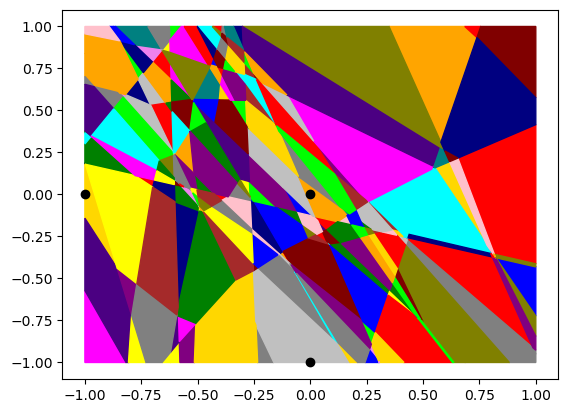

In [9]:
color_set = [
        "blue", "green", "yellow", "orange", "red", "purple", "cyan", "magenta",
        "brown", "pink", "lime", "teal", "navy", "gold", "silver", "gray",
        "maroon", "olive", "violet", "indigo"
    ]
print(len(regions))
# Color each region with a ranom color
for idx, region in enumerate(regions):
    vertices = region.convex_hull.points[region.convex_hull.vertices]
    color = random.choice(color_set)
    plt.fill(vertices[:, 0], vertices[:, 1], color=color, alpha=1)

plt.scatter(0, 0, c='black')
plt.scatter(-1, 0, c='black')
plt.scatter(0, -1, c='black')

In [10]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
total_step = len(train_loader)
n_regions = []      # Count the number of regions at each epoch
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item()}")

    regions = count_regions(model)
    n_regions.append(len(regions))

Epoch [1/20], Step [100/600], Loss: 1.446549415588379
Epoch [1/20], Step [200/600], Loss: 0.6981588006019592
Epoch [1/20], Step [300/600], Loss: 0.5467171669006348
Epoch [1/20], Step [400/600], Loss: 0.43900543451309204
Epoch [1/20], Step [500/600], Loss: 0.3100048899650574
Epoch [1/20], Step [600/600], Loss: 0.4126218557357788
Epoch [2/20], Step [100/600], Loss: 0.26266157627105713
Epoch [2/20], Step [200/600], Loss: 0.32682082056999207
Epoch [2/20], Step [300/600], Loss: 0.22697713971138
Epoch [2/20], Step [400/600], Loss: 0.3052363097667694
Epoch [2/20], Step [500/600], Loss: 0.32342660427093506
Epoch [2/20], Step [600/600], Loss: 0.23926328122615814
Epoch [3/20], Step [100/600], Loss: 0.2801998257637024
Epoch [3/20], Step [200/600], Loss: 0.433090478181839
Epoch [3/20], Step [300/600], Loss: 0.2723418176174164
Epoch [3/20], Step [400/600], Loss: 0.25636157393455505
Epoch [3/20], Step [500/600], Loss: 0.29153260588645935
Epoch [3/20], Step [600/600], Loss: 0.23534263670444489
Epoch 

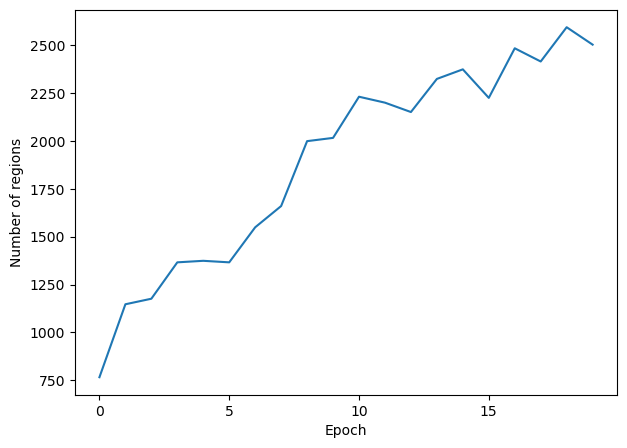

In [11]:
def plot_evolution_regions(n_epochs: int, n_regions: np.ndarray):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(np.arange(n_epochs), n_regions)
    plt.xlabel('Epoch')
    plt.ylabel('Number of regions')
    plt.xticks(np.arange(n_epochs, step=5))
    plt.show()

plot_evolution_regions(num_epochs, n_regions)

2503


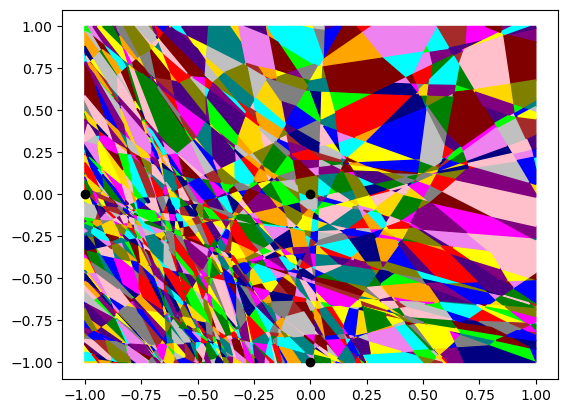

In [12]:
regions = count_regions(model)
print(len(regions))
# Color each region with a ranom color
for idx, region in enumerate(regions):
    vertices = region.convex_hull.points[region.convex_hull.vertices]
    color = random.choice(color_set)
    plt.fill(vertices[:, 0], vertices[:, 1], color=color, alpha=1)

plt.scatter(0, 0, c='black')
plt.scatter(-1, 0, c='black')
plt.scatter(0, -1, c='black')

In [128]:
"""
print(len(regions))
for region in regions:
    for simplex in region.convex_hull.simplices:
        plt.plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1])


plt.scatter(0, 0, c='r')
plt.scatter(1, 0, c='r')
plt.scatter(0, 1, c='r')
"""

"\nprint(len(regions))\nfor region in regions:\n    for simplex in region.convex_hull.simplices:\n        plt.plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1])\n\n\nplt.scatter(0, 0, c='r')\nplt.scatter(1, 0, c='r')\nplt.scatter(0, 1, c='r')\n"